## Thermal conductivity model - BPC model
- The script is written based on the article - https://gmd.copernicus.org/articles/8/2701/2015/ (Appendix A - Thermal conductivity model) 
- Author: Radhakrishna.B.L.
- Code from Ethan coon is taken- https://github.com/amanzi/ats/blob/master/tools/python_models/thermal_conductivity2.ipynb

The BPC model is described frst by this equation:

\begin{equation}
    \kappa_e = \kappa_{e,f} K_{sat,f} -  \kappa_{e,u} K_{sat,u} + (1 - \kappa_{e,u} - \kappa_{e,f})K_{dry} 
\end{equation}

Here, $\kappa_e$ is the Kersten number & K_{sat} is the thermal conductivity. Subscripts {f, u, dry} represents {frozen, unfrozen, and dry}.

The Kersten number for frozen and unfrozen is determined by a power law function defined in Painter, 2011. It relates the kersten number to saturation of liquid. 

\begin{equation}
    K_{e,u} = (s_l + \epsilon)^{\alpha_u}
\end{equation}

\begin{equation}
    K_{e,f} = (s_l + \epsilon)^{\alpha_f}
\end{equation}

It is assumed that $K_{sat, u}$ is known (either measured or calibrated with temperature measurements). To determine the thermal conductivity at a frozen state, we can use the following equation:

\begin{equation}
    K_{sat, f} = K_{sat, u} (\frac{K_i}{K_w})^{\phi}
\end{equation}

where $K_i$ and $K_w$ is the thermal conductivity of ice and water. 



In [193]:
import numpy as np

from matplotlib import pyplot as plt
from matplotlib import cm
from matplotlib import colors as ml_colors
from matplotlib.ticker import LinearLocator, FormatStrFormatter
from mpl_toolkits.mplot3d import Axes3D
import os,sys
import scipy as sp
import colors

#sys.path.append('/home/ecoon/research/python')
#import colors

In [179]:
# This is the model used in ATS - Freezeup
class ThreePhaseWetDry(TC):
    """
    To determine the thermal conductivity of the soil based on the MPC model - Three phase wet/dry
    
    PARAMETERS:
    
    ------
    INPUT:
    
    a_u - unsaturated alpha unfrozen [-]. Typical value = 0.5 (Source: freezeup.xml)
        
    a_f - unsaturated alpha frozen [-]. Typical value = 1 (Source: freezeup.xml)
    
    
    tc_dry - Dry thermal conductivity [W m^-1 K^-1]. Typical values are: 0.07 - peat, 0.29 - mineral (Source: freezeup.xml)
    
    tc_sat_u - Unfrozen saturated thermal conductivity [W m^-1 K^-1]. Typical values are: 0.67 - peat, 1.0 - mineral (Source: freezeup.xml)
    
    poro - porosity of the material. Typical value is 0.85 for peat and [0.2 - 0.5] for mineral
    
    s_r - Residual saturation. Typical values vary from 0.05 for peat to [0.1 - 0.3] for clay/sand/silt
    
    sl - Saturation of liquid- Needs to be calculated based on three cases - unfrozen, frozen and transition 
    
    si - Saturation of ice- Needs to be calculated based on three cases - unfrozen, frozen and transition 
    
    OUTPUT:
    
    The thermal conductivity of the medium
    
    """
    # Defining the constants in the equations - as per the code from Ethan 
    eps_ = 1.e-10
    
    def __init__(self, tc_sat_uf, tc_dry, a_f, a_u):
        self.a_u = a_u
        self.a_f = a_f
        self.tc_sat_uf = tc_sat_uf
        self.tc_dry = tc_dry
    def thermal_conductivity(self, poro, sl, si, T):
        
        self.poro = poro
        
        # Thermal conductivity of ice
        Ki = 831.51 * pow(T, -1.0552)
        
        # Thermal conductivity of liquid
        Kl = 0.5611;
        
        # Saturated thermal conductivity - frozen
        tc_sat_f = self.tc_sat_uf * pow(Ki/Kl, self.poro);

        kersten_u = pow(sl + self.eps_, self.a_u);
        kersten_f = pow(si + self.eps_, self.a_f);
        
        return kersten_f * tc_sat_f + kersten_u * self.tc_sat_uf + (1.0 - kersten_f - kersten_u) * self.tc_dry;
    
    def plot_end_members(self, poro, s_r, axs=None, color='k', label=None, npoints=1000):
        if axs is None:
            fig, (ax1, ax2, ax3) = plt.subplots(ncols=3)
            fig.set_size_inches(24, 8)
            #fig.title('Test')

    
            # unfrozen
            sle = np.linspace(0,1,npoints)
            sl = sle*(1-s_r) + s_r
            si = 0
            tc_u = np.array([self.thermal_conductivity(poro, s, si, 275.) for s in sl])
            ax1.plot(sle, tc_u, color=color, label=label)
            ax1.set_xlabel("1 - reduced gas saturation ")
            ax1.set_title("Unfrozen - T > 0°C, [s_i = 0]")
            ax1.set_ylabel("Thermal conductivity [W m^-1 K^-1]")
            ax1.grid(True)

            # frozen
            sie = np.linspace(0,1,1000)
            si = sie*(1-s_r)
            tc_f = np.array([self.thermal_conductivity(poro, s_r, s, 260.0) for s in si])
            ax2.plot(sie, tc_f, color=color, label=label)
            ax2.set_xlabel("1 - reduced gas saturation")
            ax2.set_title("Frozen - T << 0°C, [s_l = s_r]")
            ax2.grid(True)
            #ax3.set_ylabel("thermal conductivity")

            # transition
            sie = np.linspace(0,1,1000)
            si = sie*(1-s_r)
            tc_t = np.array([self.thermal_conductivity(poro, 1-s, s, 260.0) for s in si])
            ax3.plot(sie, tc_t, color=color, label=f'tc_sat_uf={self.tc_sat_uf}, tc_dry={self.tc_dry}, por = {self.poro}, a_f = {self.a_f}, a_u = {self.a_u}')
            ax3.set_xlabel("reduced ice saturation")
            #ax3.set_ylabel("thermal conductivity")
            ax3.set_title("Transition: sg = 0")
            ax3.legend()
            ax3.grid(True)

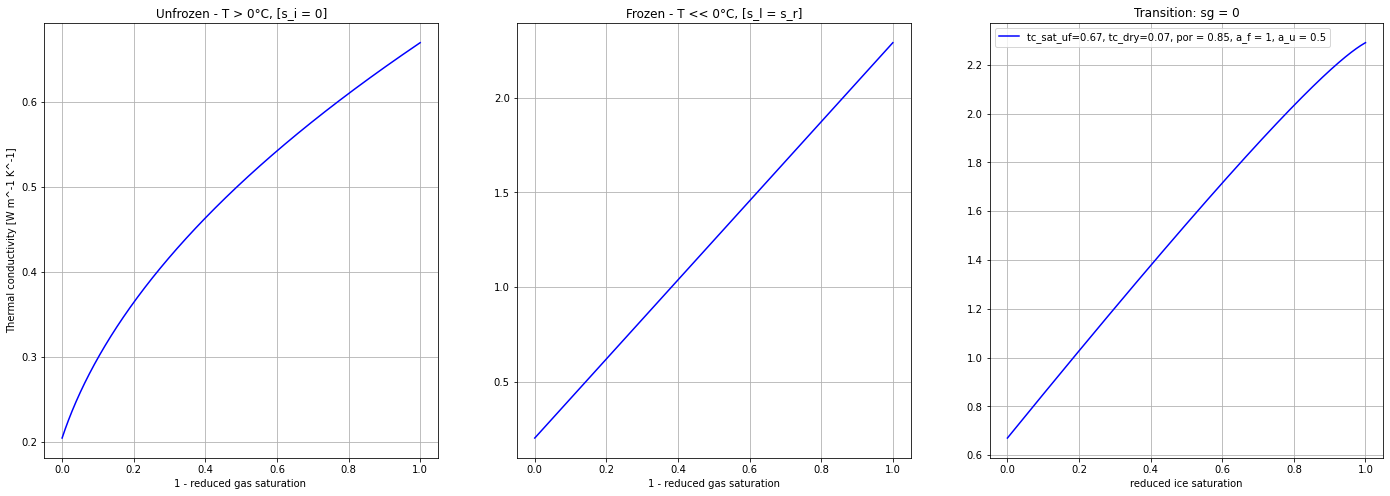

In [180]:
# Trial
tc_peat = ThreePhaseWetDry(0.67, 0.07, 1, 0.5)
tc_peat.plot_end_members(0.85, 0.05, color='b')
#tc_peat.plot_end_members(0.5, 0.2)

## Plotting the parameters:
* Peat:
    - Ppor - Porosity : [0.3, 0.5, 0.9] 
    - Ptcs - Thermal conductivity, saturated (unfrozen) : [0.2, 0.6, 1]
    - Ptcd - Thermal conductivity, dry : [0.03, 0.07, 0.12]
    - Paf - [0.5, 1.0, 1.5]
    - Pauf - [0.1, 0.5, 0.7]
* Mineral:
    - Mpor - Porosity : [0.2, 0.3, 0.5] 
    - Mtcs - Thermal conductivity, saturated (unfrozen) : [1, 1.5, 2.0]
    - Mtcd - Thermal conductivity, dry : [0.2, 0.6, 1.0]
    - Maf - [0.5, 1.0, 1.5]
    - Mauf - [0.1, 0.5, 0.7] 
* Bedrock:
    - Bpor - Porosity : [1.5, 2.0, 3.0] 
    - Btcs - Thermal conductivity, saturated (unfrozen) : [1, 1.5, 2.0]
    - Btcd - Thermal conductivity, dry : [0.5, 1.0, 1.5]
    - Baf - [0.5, 1.0, 1.5]
    - Bauf - [0.1, 0.5, 0.7] 
 
**The standard values is always the second value**

In [244]:
# Standard parameters for all cases:

# Peat
Ptcs_std = 0.6
Ptcd_std = 0.07
Paf_std = 1 
Pauf_std = 0.5
Ppor_std = 0.5

# Mineral
Mtcs_std = 1.5
Mtcd_std = 0.6
Maf_std = 1 
Mauf_std = 0.5
Mpor_std = 0.3

# Bedrock
Btcs_std = 2
Btcd_std = 1.0
Baf_std = 1.0 
Bauf_std = 0.5
Bpor_std = 0.3


In [245]:
# Variation of parameters:

# Peat
Ptcs = [0.2, 0.6, 1.0]
Ptcd = [0.03, 0.07, 0.12]
Paf = [0.5, 1.0, 1.5] 
Pauf = [0.1, 0.5, 0.7]
Ppor = [0.3, 0.5, 0.9]

# Mineral
Mtcs = [1, 1.5, 2]
Mtcd = [0.2, 0.6, 1.0]
Maf = [0.5, 1, 1.5] 
Mauf = [0.1, 0.5, 0.7]
Mpor = [0.2, 0.3, 0.5]

# Bedrock
Btcs = [1.5, 2, 3]
Btcd = [0.5, 1, 1.5]
Baf = [0.5, 1, 1.5] 
Bauf = [0.1, 0.5, 0.7]
Bpor = [0.2, 0.3, 0.5]

### Peat:
#### Porosity

In [252]:
# Test
tc_test = ThreePhaseWetDry(Ptcs_std, Ptcd_std, Paf_std, Pauf_std)
tc_test.thermal_conductivity(poro=0.2, sl=0.5,si=0.3, T =260)

0.6635294877533005

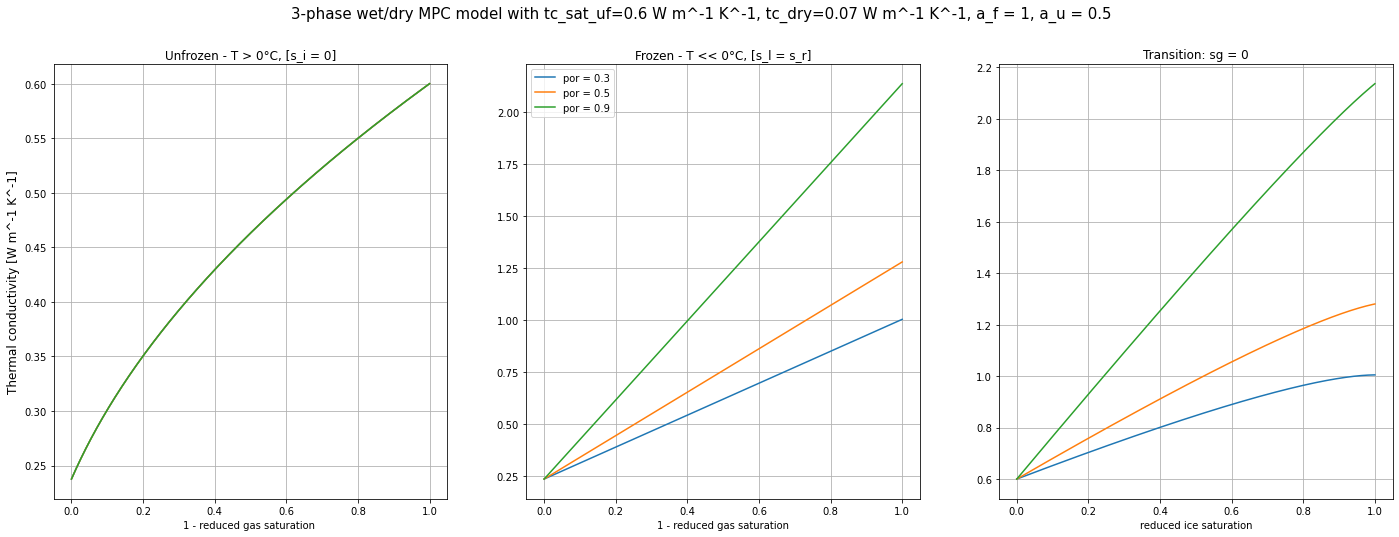

In [255]:
fig, (ax1, ax2, ax3) = plt.subplots(ncols=3)
fig.set_size_inches(24, 8)
fig.suptitle(f'Peat - porosity - 3-phase wet/dry MPC model with tc_sat_uf={Ptcs_std} W m^-1 K^-1, tc_dry={Ptcd_std} W m^-1 K^-1, a_f = {Paf_std}, a_u = {Pauf_std}', fontsize=15)

# Defining a color label
color_label_water = colors.cm_mapper(vmin=0.0, vmax=3.0, cmap=colors.water_cmap())



# Creating an object - peat
tc_Ppor = ThreePhaseWetDry(Ptcs_std, Ptcd_std, Paf_std, Pauf_std)
    
# unfrozen
sle = np.linspace(0, 1, npoints)
sl = sle*(1-s_r) + s_r
si = 0

tc_u_1 = np.array([tc_Ppor.thermal_conductivity(Ppor[0], s, si, 275.) for s in sl])
tc_u_2 = np.array([tc_Ppor.thermal_conductivity(Ppor[1], s, si, 275.) for s in sl])
tc_u_3 = np.array([tc_Ppor.thermal_conductivity(Ppor[2], s, si, 275.) for s in sl])

ax1.plot(sle, tc_u_1, label=f'por = {Ppor[0]}')
ax1.plot(sle, tc_u_2, label=f'por = {Ppor[1]}')
ax1.plot(sle, tc_u_3, label=f'por = {Ppor[2]}')

ax1.set_xlabel("1 - reduced gas saturation ")
ax1.set_title("Unfrozen - T > 0°C, [s_i = 0]")
ax1.set_ylabel("Thermal conductivity [W m^-1 K^-1]", fontsize=12)
ax1.grid(True)
#ax1.legend()

# frozen
sie = np.linspace(0,1,1000)
si = sie*(1-s_r)

tc_f_1 = np.array([tc_Ppor.thermal_conductivity(Ppor[0], s_r, s, 260.0) for s in si])
tc_f_2 = np.array([tc_Ppor.thermal_conductivity(Ppor[1], s_r, s, 260.0) for s in si])
tc_f_3 = np.array([tc_Ppor.thermal_conductivity(Ppor[2], s_r, s, 260.0) for s in si])

ax2.plot(sle, tc_f_1, label=f'por = {Ppor[0]}')
ax2.plot(sle, tc_f_2, label=f'por = {Ppor[1]}')
ax2.plot(sle, tc_f_3, label=f'por = {Ppor[2]}')

ax2.set_xlabel("1 - reduced gas saturation")
ax2.set_title("Frozen - T << 0°C, [s_l = s_r]")
ax2.grid(True)
ax2.legend()
#ax3.set_ylabel("thermal conductivity")

# transition
sie = np.linspace(0,1,1000)
si = sie*(1-s_r)

tc_t_1 = np.array([tc_Ppor.thermal_conductivity(Ppor[0], 1-s, s, 260.0) for s in si])
tc_t_2 = np.array([tc_Ppor.thermal_conductivity(Ppor[1], 1-s, s, 260.0) for s in si])
tc_t_3 = np.array([tc_Ppor.thermal_conductivity(Ppor[2], 1-s, s, 260.0) for s in si])

ax3.plot(sle, tc_t_1, label=f'por = {Ppor[0]}')
ax3.plot(sle, tc_t_2, label=f'por = {Ppor[1]}')
ax3.plot(sle, tc_t_3, label=f'por = {Ppor[2]}')


ax3.set_xlabel("reduced ice saturation")
#ax3.set_ylabel("thermal conductivity")
ax3.set_title("Transition: sg = 0")
#ax3.legend()
ax3.grid(True)

* Comments:
    - As the porosity increases, the thermal conductivity of the medium under frozen and transition conditions also increases
    - For the unfrozen state, the thermal conductivity remains constant since K_ef almost equal to 0

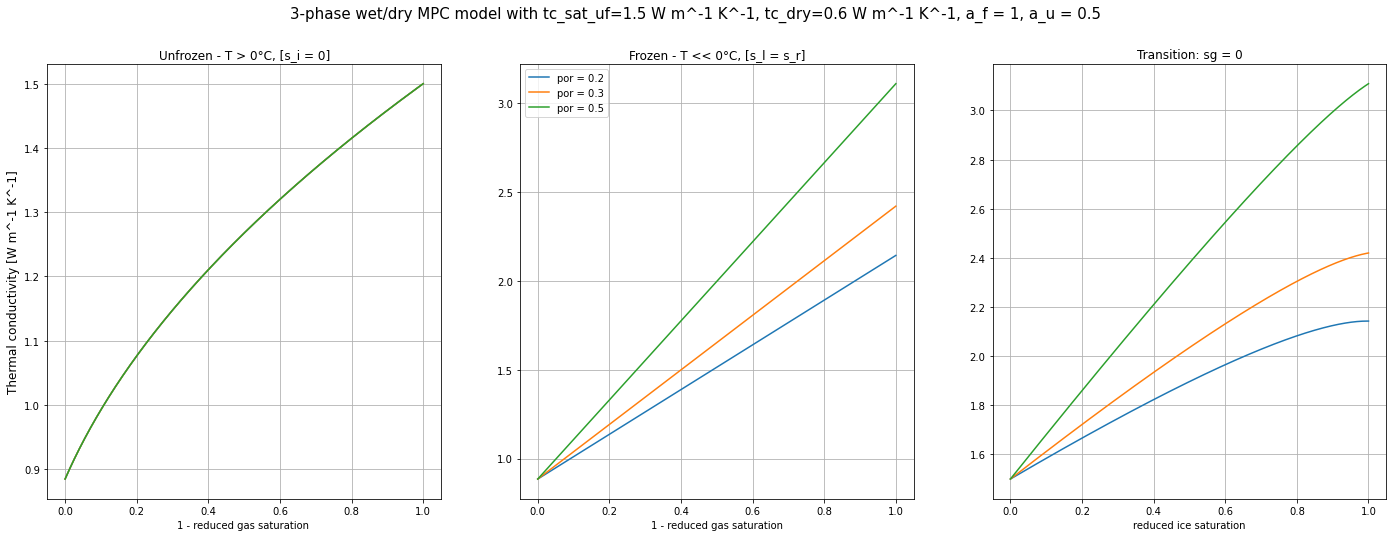

In [256]:
fig, (ax1, ax2, ax3) = plt.subplots(ncols=3)
fig.set_size_inches(24, 8)
fig.suptitle(f'Mineral - porosity - 3-phase wet/dry MPC model with tc_sat_uf={Mtcs_std} W m^-1 K^-1, tc_dry={Mtcd_std} W m^-1 K^-1, a_f = {Maf_std}, a_u = {Mauf_std}', fontsize=15)

# Defining a color label
color_label_water = colors.cm_mapper(vmin=0.0, vmax=3.0, cmap=colors.water_cmap())


# Creating an object - peat
tc_Mpor = ThreePhaseWetDry(Mtcs_std, Mtcd_std, Maf_std, Mauf_std)
    
# unfrozen
sle = np.linspace(0, 1, npoints)
sl = sle*(1-s_r) + s_r
si = 0

tc_u_1 = np.array([tc_Mpor.thermal_conductivity(Mpor[0], s, si, 275.) for s in sl])
tc_u_2 = np.array([tc_Mpor.thermal_conductivity(Mpor[1], s, si, 275.) for s in sl])
tc_u_3 = np.array([tc_Mpor.thermal_conductivity(Mpor[2], s, si, 275.) for s in sl])

ax1.plot(sle, tc_u_1, label=f'por = {Mpor[0]}')
ax1.plot(sle, tc_u_2, label=f'por = {Mpor[1]}')
ax1.plot(sle, tc_u_3, label=f'por = {Mpor[2]}')

ax1.set_xlabel("1 - reduced gas saturation ")
ax1.set_title("Unfrozen - T > 0°C, [s_i = 0]")
ax1.set_ylabel("Thermal conductivity [W m^-1 K^-1]", fontsize=12)
ax1.grid(True)
#ax1.legend()

# frozen
sie = np.linspace(0,1,1000)
si = sie*(1-s_r)

tc_f_1 = np.array([tc_Mpor.thermal_conductivity(Mpor[0], s_r, s, 260.0) for s in si])
tc_f_2 = np.array([tc_Mpor.thermal_conductivity(Mpor[1], s_r, s, 260.0) for s in si])
tc_f_3 = np.array([tc_Mpor.thermal_conductivity(Mpor[2], s_r, s, 260.0) for s in si])

ax2.plot(sle, tc_f_1, label=f'por = {Mpor[0]}')
ax2.plot(sle, tc_f_2, label=f'por = {Mpor[1]}')
ax2.plot(sle, tc_f_3, label=f'por = {Mpor[2]}')

ax2.set_xlabel("1 - reduced gas saturation")
ax2.set_title("Frozen - T << 0°C, [s_l = s_r]")
ax2.grid(True)
ax2.legend()
#ax3.set_ylabel("thermal conductivity")

# transition
sie = np.linspace(0,1,1000)
si = sie*(1-s_r)

tc_t_1 = np.array([tc_Mpor.thermal_conductivity(Mpor[0], 1-s, s, 260.0) for s in si])
tc_t_2 = np.array([tc_Mpor.thermal_conductivity(Mpor[1], 1-s, s, 260.0) for s in si])
tc_t_3 = np.array([tc_Mpor.thermal_conductivity(Mpor[2], 1-s, s, 260.0) for s in si])

ax3.plot(sle, tc_t_1, label=f'por = {Mpor[0]}')
ax3.plot(sle, tc_t_2, label=f'por = {Mpor[1]}')
ax3.plot(sle, tc_t_3, label=f'por = {Mpor[2]}')


ax3.set_xlabel("reduced ice saturation")
#ax3.set_ylabel("thermal conductivity")
ax3.set_title("Transition: sg = 0")
#ax3.legend()
ax3.grid(True)

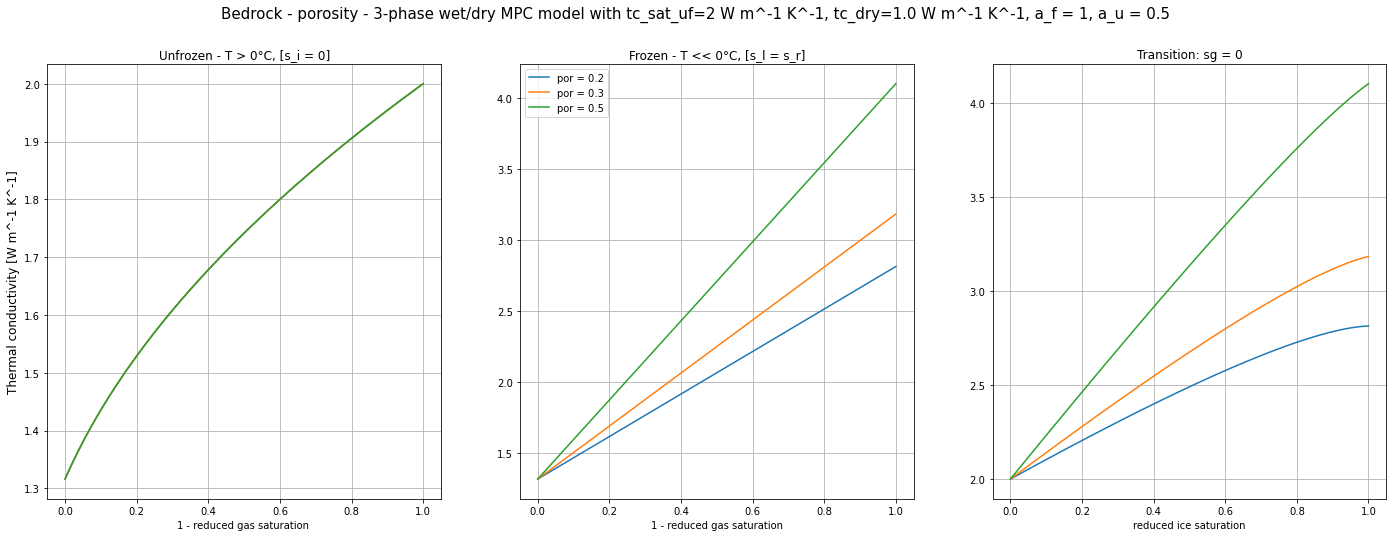

In [258]:
fig, (ax1, ax2, ax3) = plt.subplots(ncols=3)
fig.set_size_inches(24, 8)
fig.suptitle(f'Bedrock - porosity - 3-phase wet/dry MPC model with tc_sat_uf={Btcs_std} W m^-1 K^-1, tc_dry={Btcd_std} W m^-1 K^-1, a_f = {Maf_std}, a_u = {Bauf_std}', fontsize=15)

# Defining a color label
color_label_water = colors.cm_mapper(vmin=0.0, vmax=3.0, cmap=colors.water_cmap())


# Creating an object - peat
tc_Bpor = ThreePhaseWetDry(Btcs_std, Btcd_std, Baf_std, Bauf_std)
    
# unfrozen
sle = np.linspace(0, 1, npoints)
sl = sle*(1-s_r) + s_r
si = 0

tc_u_1 = np.array([tc_Bpor.thermal_conductivity(Bpor[0], s, si, 275.) for s in sl])
tc_u_2 = np.array([tc_Bpor.thermal_conductivity(Bpor[1], s, si, 275.) for s in sl])
tc_u_3 = np.array([tc_Bpor.thermal_conductivity(Bpor[2], s, si, 275.) for s in sl])

ax1.plot(sle, tc_u_1, label=f'por = {Bpor[0]}')
ax1.plot(sle, tc_u_2, label=f'por = {Bpor[1]}')
ax1.plot(sle, tc_u_3, label=f'por = {Bpor[2]}')

ax1.set_xlabel("1 - reduced gas saturation ")
ax1.set_title("Unfrozen - T > 0°C, [s_i = 0]")
ax1.set_ylabel("Thermal conductivity [W m^-1 K^-1]", fontsize=12)
ax1.grid(True)
#ax1.legend()

# frozen
sie = np.linspace(0,1,1000)
si = sie*(1-s_r)

tc_f_1 = np.array([tc_Bpor.thermal_conductivity(Bpor[0], s_r, s, 260.0) for s in si])
tc_f_2 = np.array([tc_Bpor.thermal_conductivity(Bpor[1], s_r, s, 260.0) for s in si])
tc_f_3 = np.array([tc_Bpor.thermal_conductivity(Bpor[2], s_r, s, 260.0) for s in si])

ax2.plot(sle, tc_f_1, label=f'por = {Bpor[0]}')
ax2.plot(sle, tc_f_2, label=f'por = {Bpor[1]}')
ax2.plot(sle, tc_f_3, label=f'por = {Bpor[2]}')

ax2.set_xlabel("1 - reduced gas saturation")
ax2.set_title("Frozen - T << 0°C, [s_l = s_r]")
ax2.grid(True)
ax2.legend()
#ax3.set_ylabel("thermal conductivity")

# transition
sie = np.linspace(0,1,1000)
si = sie*(1-s_r)

tc_t_1 = np.array([tc_Bpor.thermal_conductivity(Bpor[0], 1-s, s, 260.0) for s in si])
tc_t_2 = np.array([tc_Bpor.thermal_conductivity(Bpor[1], 1-s, s, 260.0) for s in si])
tc_t_3 = np.array([tc_Bpor.thermal_conductivity(Bpor[2], 1-s, s, 260.0) for s in si])

ax3.plot(sle, tc_t_1, label=f'por = {Bpor[0]}')
ax3.plot(sle, tc_t_2, label=f'por = {Bpor[1]}')
ax3.plot(sle, tc_t_3, label=f'por = {Bpor[2]}')


ax3.set_xlabel("reduced ice saturation")
#ax3.set_ylabel("thermal conductivity")
ax3.set_title("Transition: sg = 0")
#ax3.legend()
ax3.grid(True)

In [ ]:
# This is the model used in ATS - Freezeup
class ThreePhaseWetDry(TC):
    """
    To determine the thermal conductivity of the soil based on the MPC model - Three phase wet/dry
    
    PARAMETERS:
    
    ------
    INPUT:
    
    a_u - unsaturated alpha unfrozen [-]. Typical value = 0.5 (Source: freezeup.xml)
        
    a_f - unsaturated alpha frozen [-]. Typical value = 1 (Source: freezeup.xml)
    
    
    tc_dry - Dry thermal conductivity [W m^-1 K^-1]. Typical values are: 0.07 - peat, 0.29 - mineral (Source: freezeup.xml)
    
    tc_sat_u - Unfrozen saturated thermal conductivity [W m^-1 K^-1]. Typical values are: 0.67 - peat, 1.0 - mineral (Source: freezeup.xml)
    
    poro - porosity of the material. Typical value is 0.85 for peat and [0.2 - 0.5] for mineral
    
    s_r - Residual saturation. Typical values vary from 0.05 for peat to [0.1 - 0.3] for clay/sand/silt
    
    sl - Saturation of liquid- Needs to be calculated based on three cases - unfrozen, frozen and transition 
    
    si - Saturation of ice- Needs to be calculated based on three cases - unfrozen, frozen and transition 
    
    OUTPUT:
    
    The thermal conductivity of the medium
    
    """
    # Defining the constants in the equations - as per the code from Ethan 
    eps_ = 1.e-10
    
    def __init__(self, tc_sat_uf, tc_dry, a_f, a_u):
        self.a_u = a_u
        self.a_f = a_f
        self.tc_sat_uf = tc_sat_uf
        self.tc_dry = tc_dry
    def thermal_conductivity(self, poro, sl, si, T):
        
        self.poro = poro
        
        # Thermal conductivity of ice
        Ki = 831.51 * pow(T, -1.0552)
        
        # Thermal conductivity of liquid
        Kl = 0.5611;
        
        # Saturated thermal conductivity - frozen
        tc_sat_f = self.tc_sat_uf * pow(Ki/Kl, self.poro);

        kersten_u = pow(sl + self.eps_, self.a_u);
        kersten_f = pow(si + self.eps_, self.a_f);
        
        return kersten_f * tc_sat_f + kersten_u * self.tc_sat_uf + (1.0 - kersten_f - kersten_u) * self.tc_dry;
    
    def plot_end_members(self, poro, s_r, axs=None, color='k', label=None, npoints=1000):
        if axs is None:
            fig, (ax1, ax2, ax3) = plt.subplots(ncols=3)
            fig.set_size_inches(24, 8)
            #fig.title('Test')

    
            # unfrozen
            sle = np.linspace(0,1,npoints)
            sl = sle*(1-s_r) + s_r
            si = 0
            tc_u = np.array([self.thermal_conductivity(poro, s, si, 275.) for s in sl])
            ax1.plot(sle, tc_u, color=color, label=label)
            ax1.set_xlabel("1 - reduced gas saturation ")
            ax1.set_title("Unfrozen - T > 0°C, [s_i = 0]")
            ax1.set_ylabel("Thermal conductivity [W m^-1 K^-1]")
            ax1.grid(True)

            # frozen
            sie = np.linspace(0,1,1000)
            si = sie*(1-s_r)
            tc_f = np.array([self.thermal_conductivity(poro, s_r, s, 260.0) for s in si])
            ax2.plot(sie, tc_f, color=color, label=label)
            ax2.set_xlabel("1 - reduced gas saturation")
            ax2.set_title("Frozen - T << 0°C, [s_l = s_r]")
            ax2.grid(True)
            #ax3.set_ylabel("thermal conductivity")

            # transition
            sie = np.linspace(0,1,1000)
            si = sie*(1-s_r)
            tc_t = np.array([self.thermal_conductivity(poro, 1-s, s, 260.0) for s in si])
            ax3.plot(sie, tc_t, color=color, label=f'tc_sat_uf={self.tc_sat_uf}, tc_dry={self.tc_dry}, por = {self.poro}, a_f = {self.a_f}, a_u = {self.a_u}')
            ax3.set_xlabel("reduced ice saturation")
            #ax3.set_ylabel("thermal conductivity")
            ax3.set_title("Transition: sg = 0")
            ax3.legend()
            ax3.grid(True)

### Trials   

In [132]:
class TC_MPC(TC):
    """
    To determine the thermal conductivity of the soil based on the MPC model - Three phase wet/dry
    
    PARAMETERS:
    
    ------
    INPUT:
    
    a_u - unsaturated alpha unfrozen [-]. Typical value = 0.5 (Source: freezeup.xml)
        
    a_f - unsaturated alpha frozen [-]. Typical value = 1 (Source: freezeup.xml)
    
    
    k_dry - Dry thermal conductivity [W m^-1 K^-1]. Typical values are: 0.07 - peat, 0.29 - mineral (Source: freezeup.xml)
    
    k_sat_u - Unfrozen saturated thermal conductivity [W m^-1 K^-1]. Typical values are: 0.67 - peat, 1.0 - mineral (Source: freezeup.xml)
    
    poro - porosity of the material. Typical value is 0.85 for peat and [0.2 - 0.5] for mineral
    
    s_r - Residual saturation. Typical values vary from 0.05 for peat to [0.1 - 0.3] for clay/sand/silt
    
    sl - Saturation of liquid- Needs to be calculated based on three cases - unfrozen, frozen and transition 
    
    si - Saturation of ice- Needs to be calculated based on three cases - unfrozen, frozen and transition 
    
    OUTPUT:
    
    The thermal conductivity of the medium
    
    """
    
    # Defining the constants in the equations - as per the code from Ethan 
    eps_ = 1.e-10
    
    def __init__(self, a_u, a_f, k_dry, k_sat_u, poro, s_r, k_gas=0.024, k_liq=0.5611, k_ice=2.21):
        self.a_u = a_u
        self.a_f = a_f
        self.k_dry = k_dry
        self.k_sat_u = k_sat_u
        self.poro = poro
        self.k_gas = k_gas
        self.k_liq = k_liq
        self.k_ice = k_ice
        self.s_r = s_r
        
        
    def thermal_conductivity(self, sl, si):
        if sl + si > 1: return np.nan
        
        
        
        # Kersten number unfrozen
        kersten_u = pow(sl + self.eps_, self.a_u)
        
        # Kersten number frozen
        kersten_f = pow(si + self.eps_, self.a_f)
        
        # Thermal conductivity - saturated frozen
        k_sat_f = self.k_sat_u * pow((self.k_ice/self.k_liq), self.poro)
        
        # Thermal conductivity of the medium
        k_m = kersten_f * k_sat_f - kersten_u * self.k_sat_u + (1 - kersten_f - kersten_u) * self.k_dry
        
        return k_m
    
    def plot_end_members(self, axs=None, color='k', label=None, npoints=1000):
        if axs is None:
            fig, (ax1, ax2, ax3) = plt.subplots(ncols=3)
            fig.set_size_inches(16, 6)
            
    
            # unfrozen
            sle = np.linspace(0,1,npoints)
            sl = sle*(1-s_r) + s_r
            si = 0
            tc_u = np.array([self.thermal_conductivity(s, si) for s in sl])
            # why do I need to give a negative sign?
            ax1.plot(sle, -tc_u, color=color, label=label)
            ax1.set_xlabel("s_l = 1 - s_g")
            ax1.set_title("Unfrozen - T > 0 (s_i = 0)")
            ax1.set_ylabel("Thermal conductivity (W m^-1 K^-1)")
            #ax1.set_xlim(0.1, 1.0)

            # frozen
            sie = np.linspace(0,1,1000)
            si = sie*(1-s_r)
            tc_f = np.array([self.thermal_conductivity(self.s_r, s) for s in si])
            ax2.plot(sie, tc_f, color=color, label=label)
            ax2.set_xlabel("s_i = 1 - reduced gas saturation")
            ax2.set_title("Frozen - T << 0 (s_l = s_r)")
            #ax2.set_xlim(0.1, 1.0)
            #ax2.set_ylabel("thermal conductivity")

            # transition
            sie = np.linspace(0,1,1000)
            si = sie*(1-s_r)
            tc_t = np.array([self.thermal_conductivity(1-s, s) for s in si])
            ax3.plot(sie, tc_t, color=color, label=label)
            ax3.set_xlabel("reduced ice saturation")
            #ax3.set_ylabel("thermal conductivity")
            ax3.set_title("Transition - sg = 0")
            #ax3.set_xlim(0.1, 1.0)

In [133]:
# Defining an object that determines the thermal conductivity
tc_peat = TC_MPC(a_u = 0.1, a_f = 1.0, k_dry = 0.3, k_sat_u = 0.67, poro = 0.85, s_r=0.1)
tc_peat_2 = TC_MPC(a_u = 0.5, a_f = 1.5, k_dry = 0.07, k_sat_u = 0.67, poro = 0.85, s_r=0.1)

# Test
tc_peat.thermal_conductivity(sl = 0.4, si = 0.2)

-0.2153814611487877

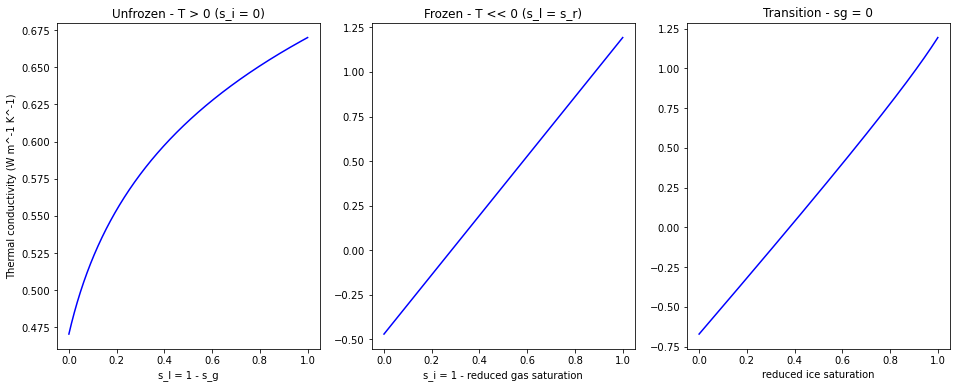

In [134]:
# Plotting for different saturations for unfrozen, frozen, transition:
tc_peat.plot_end_members(color='b')
# Why are negative values tak

In [ ]:
# Trying to plot the values 